In [1]:

from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

import glob


In [2]:
# Copy and modify the ParallaxMetric

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 120, 20),
                 atm_err=0.01, normalize=False, **kwargs):
        Cols = [m5Col, filterCol, seeingCol, 'ra_pi_amp', 'dec_pi_amp']
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_utils/2.13.0.sims-44-g40e226b+23f78951f2/python/lsst/sims/utils/stellarMags.py:101: FutureWarning: fromrecords expected a list of tuples, may have received a list of lists instead. In the future that will raise an error
  dtype=list(zip(names, types)))


Found 2044129 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_2_nslice2_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803173 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_2_nslice2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.653  dipole: lon: 98.5989, lat: -82.5727, amp: 10.569
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.258524  dipole: lon: -81.0309, lat: -68.4464, amp: 0.444568
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2044257 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_2_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 802957 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_2_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.674  dipole: lon: 98.5152, lat: -82.715, amp: 10.4557
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.26925  dipole: lon: -75.8497, lat: -67.0941, amp: 0.435279
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2045544 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_4_nslice2_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803023 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_4_nslice2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.6472  dipole: lon: 100.334, lat: -82.4216, amp: 10.5428
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.276395  dipole: lon: -79.809, lat: -67.6261, amp: 0.431321
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2045594 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_4_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803161 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_4_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7121  dipole: lon: 98.3214, lat: -82.7692, amp: 10.3864
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.278739  dipole: lon: -78.1466, lat: -69.3028, amp: 0.440664
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2045806 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_6_nslice2_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 804155 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_6_nslice2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.6648  dipole: lon: 99.1003, lat: -82.5935, amp: 10.4409
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.296664  dipole: lon: -82.3305, lat: -67.7412, amp: 0.414103
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2046634 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_6_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803793 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_6_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7871  dipole: lon: 102.697, lat: -83.0067, amp: 10.238
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.294378  dipole: lon: -77.0094, lat: -68.8409, amp: 0.440866
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2046999 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_8_nslice2_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 804295 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_8_nslice2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7416  dipole: lon: 104.582, lat: -82.9923, amp: 10.3862
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.30888  dipole: lon: -84.0837, lat: -68.2817, amp: 0.419381
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2047446 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_8_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803916 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_8_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7318  dipole: lon: 105.601, lat: -83.1878, amp: 10.5426
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.308578  dipole: lon: -77.7021, lat: -68.8601, amp: 0.438741
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2047294 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_9_nslice2_v1_7_10yrs_L7_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7119  dipole: lon: 107.119, lat: -82.8851, amp: 10.3858
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.308526  dipole: lon: -85.8227, lat: -68.1712, amp: 0.425738
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2048229 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_9_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 804786 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale0_9_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.8315  dipole: lon: 106.737, lat: -83.4294, amp: 10.2931
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.323752  dipole: lon: -78.9912, lat: -68.1273, amp: 0.430386
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2047322 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale1_0_nslice2_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 803747 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale1_0_nslice2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.7066  dipole: lon: 106.431, lat: -83.0199, amp: 10.4007
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.313496  dipole: lon: -90.2399, lat: -68.8468, amp: 0.423135
  mono, lon, lat, amp


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fieldDec'].
Found 2049096 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale1_0_nslice3_v1_7_10yrs_L7_HEAL']


/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/utils/astrometryUtils.py:72: RuntimeWarning: divide by zero encountered in true_divide
  result = fwhm/(snr)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" or filter="y" for columns ['observationStartLST', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'altitude', 'seeingFwhmGeom', 'fieldDec']
Found 804974 visits
Running:  ['_sims_maf_fbs_1_7_rolling_rolling_scale1_0_nslice3_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 37.8371  dipole: lon: 111.252, lat: -83.5952, amp: 10.2276
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="z" or filter="y"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 0.325842  dipole: lon: -80.2439, lat: -69.187, amp: 0.439992
  mono, lon, lat, amp


Plotting complete.


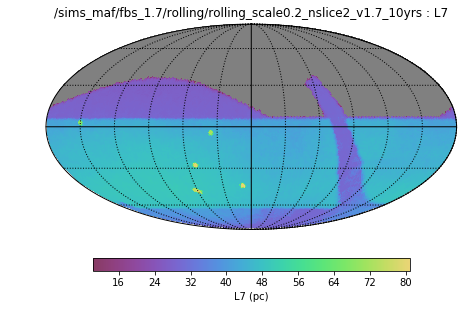

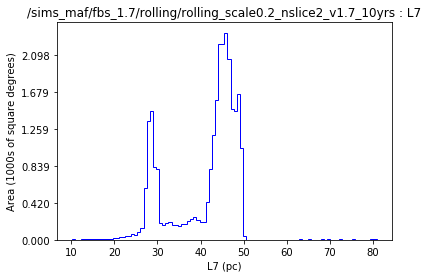

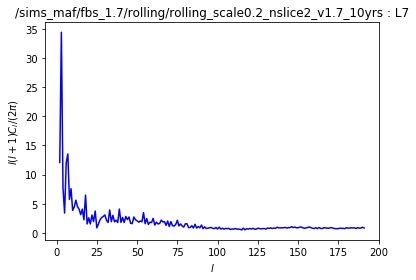

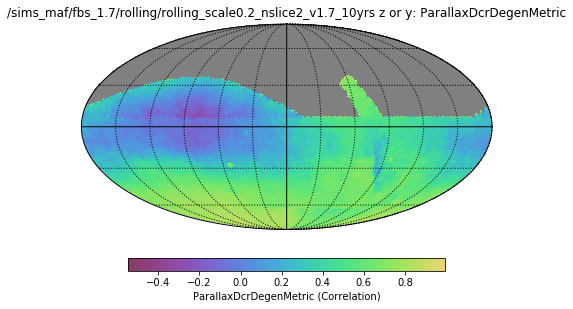

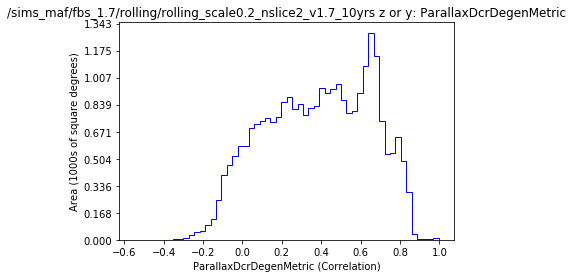

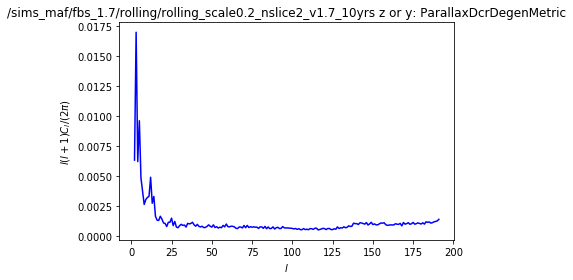

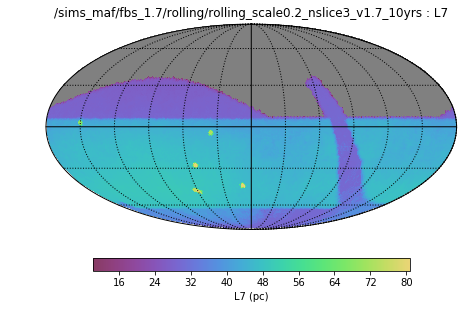

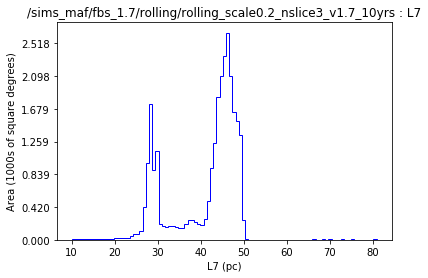

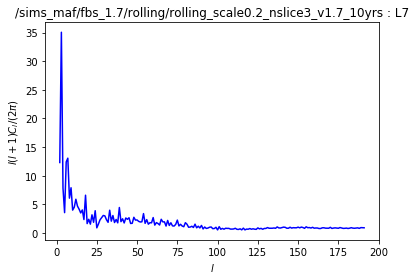

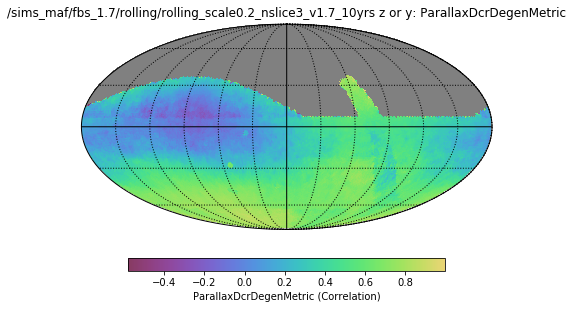

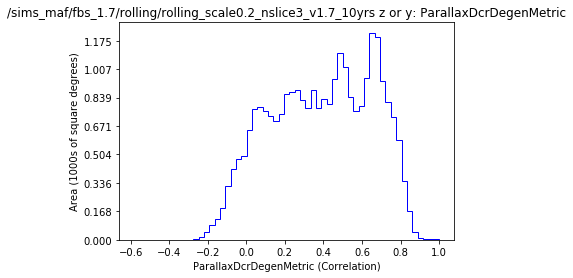

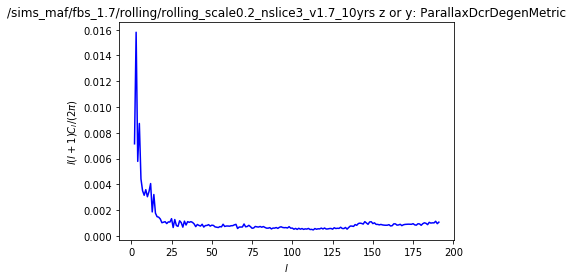

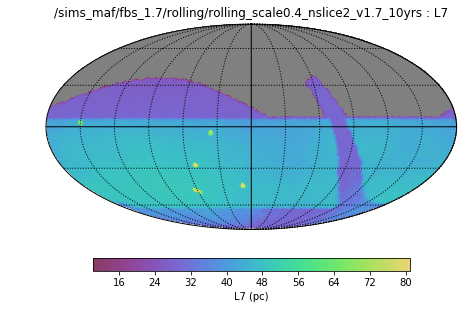

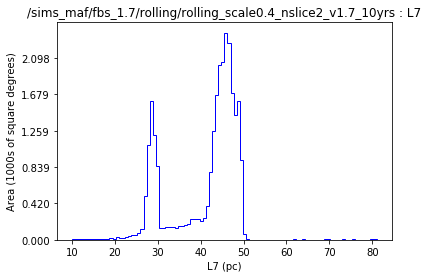

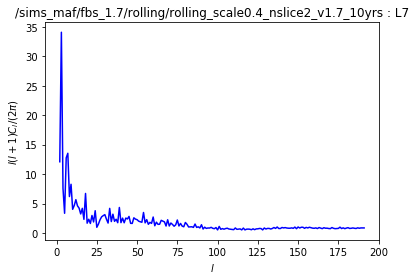

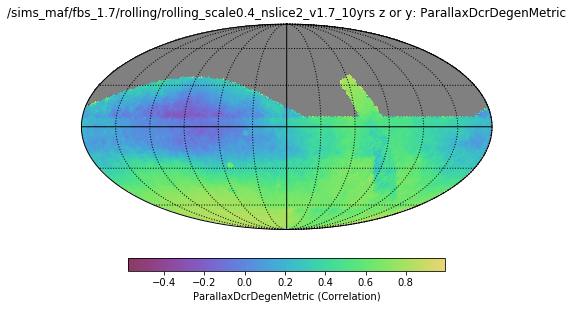

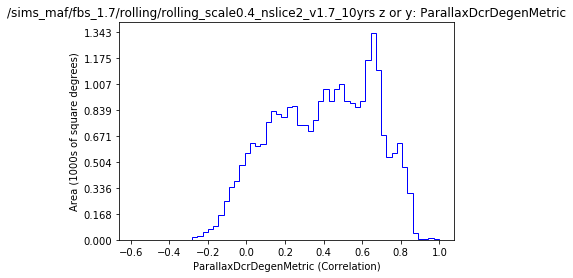

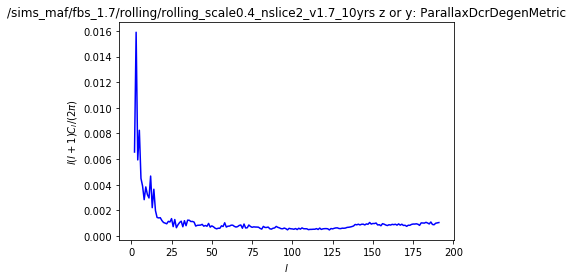

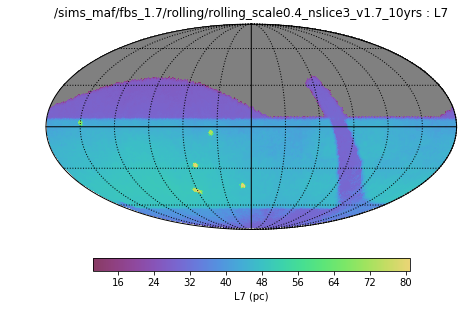

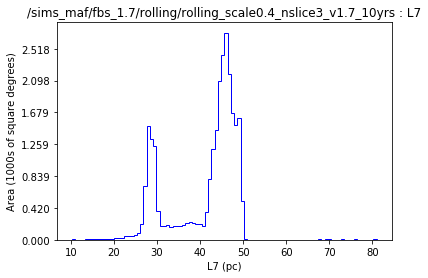

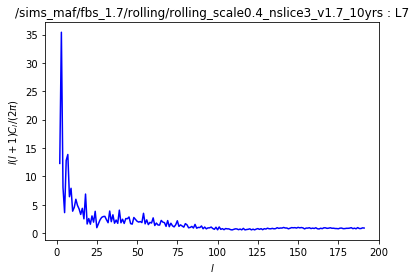

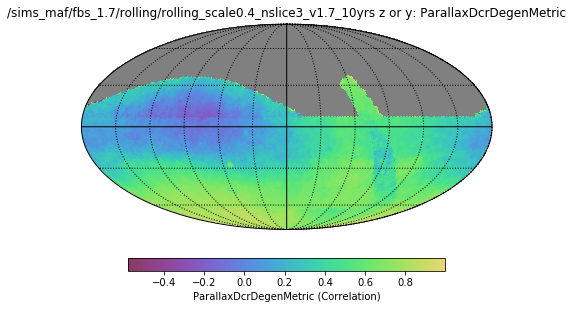

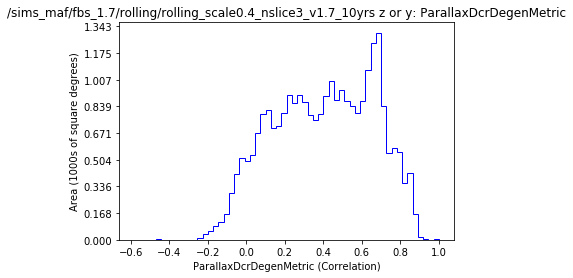

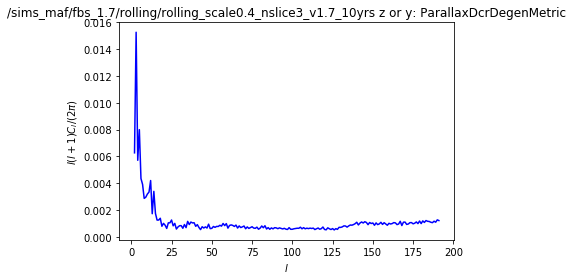

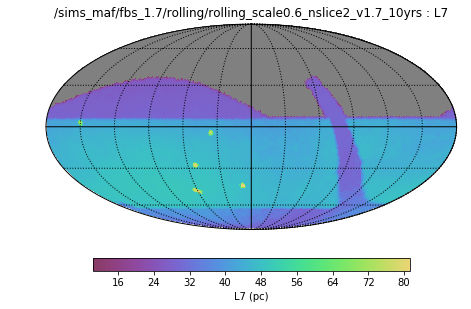

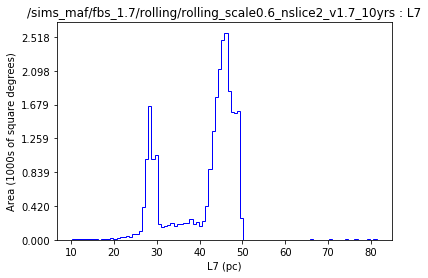

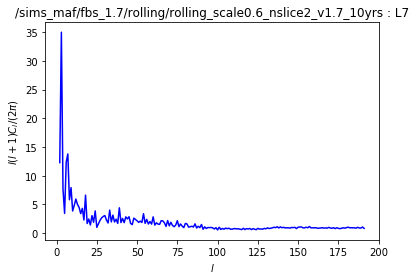

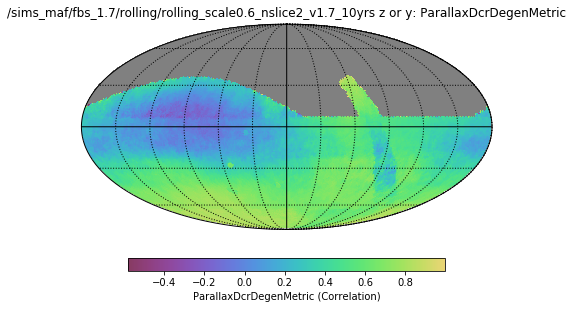

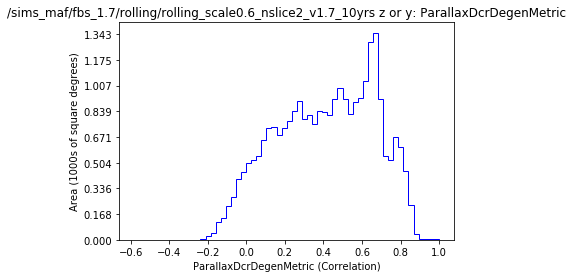

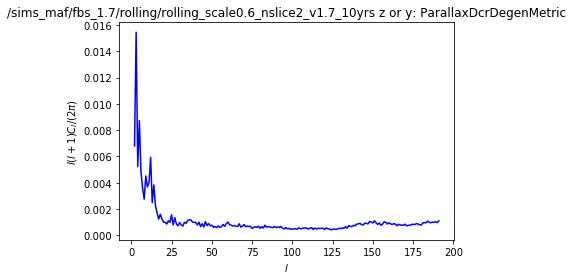

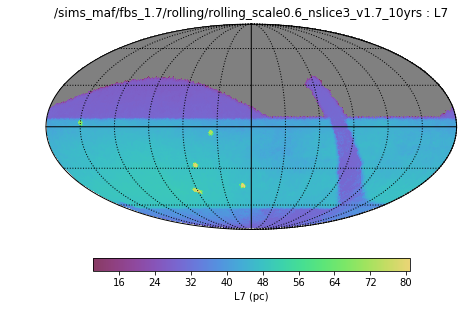

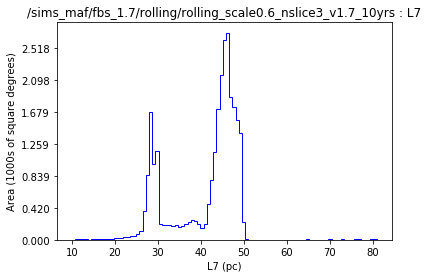

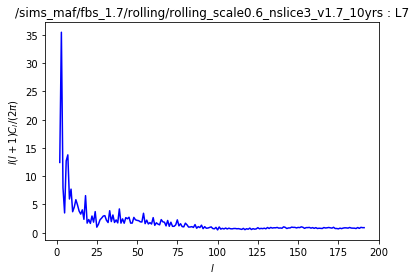

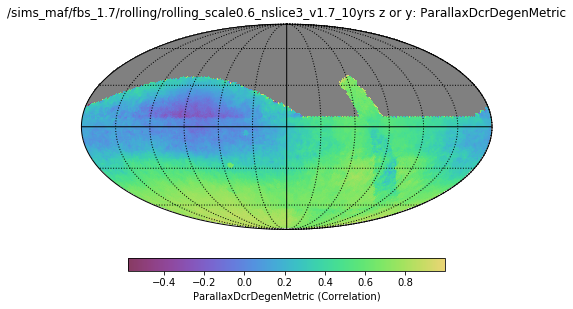

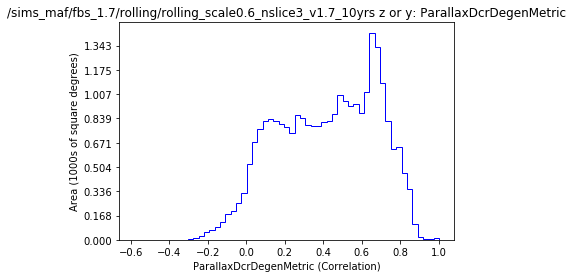

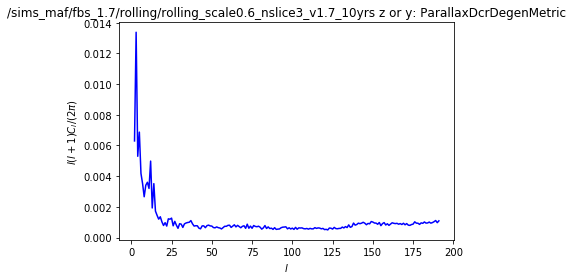

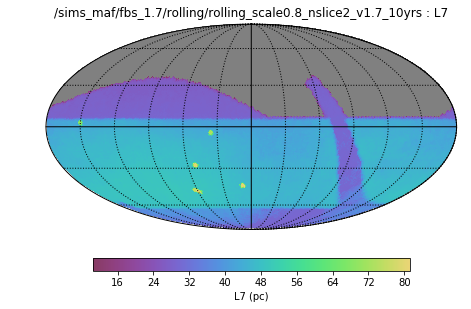

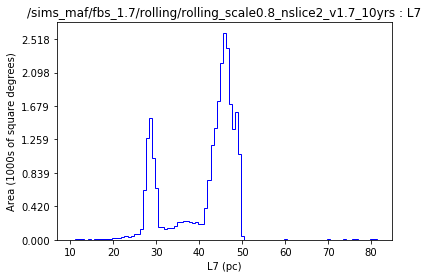

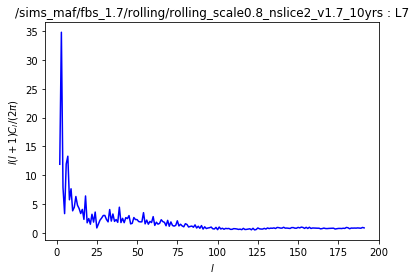

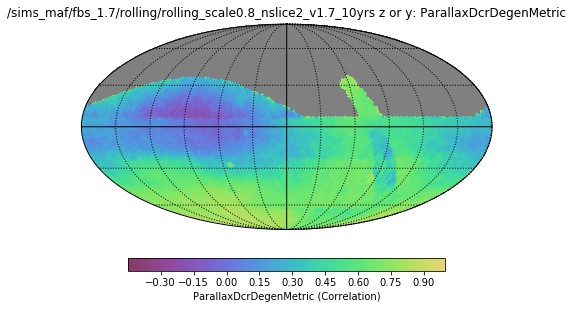

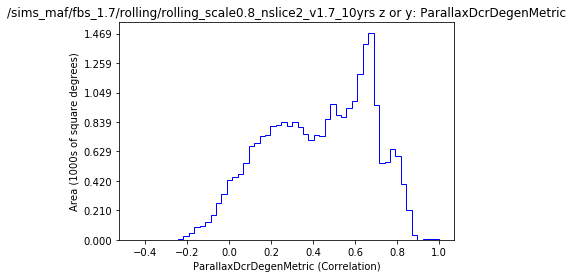

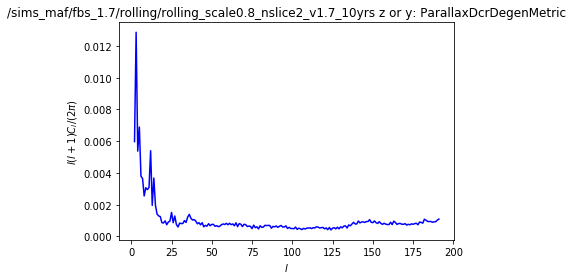

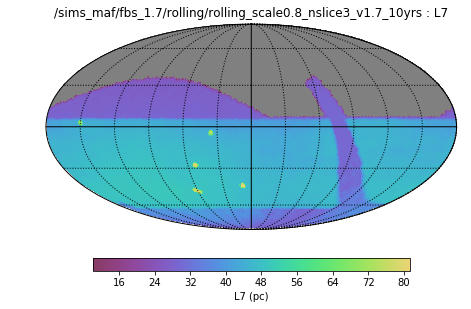

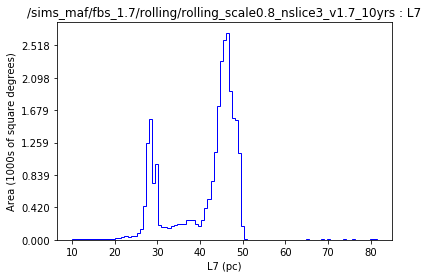

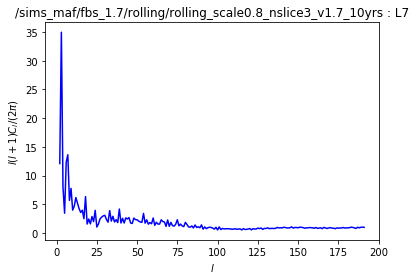

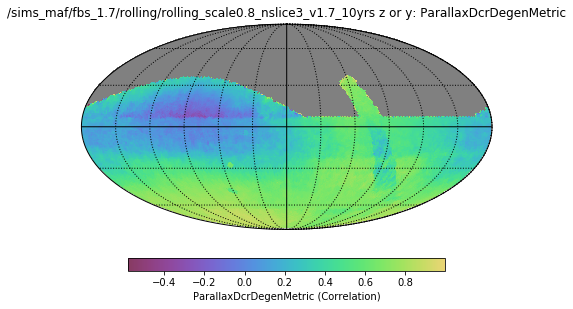

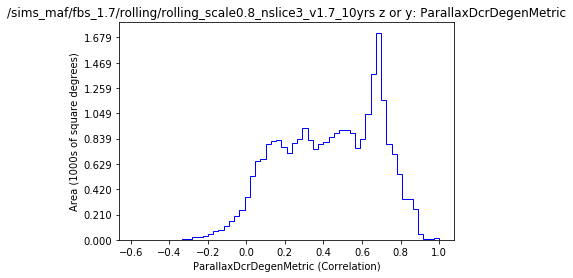

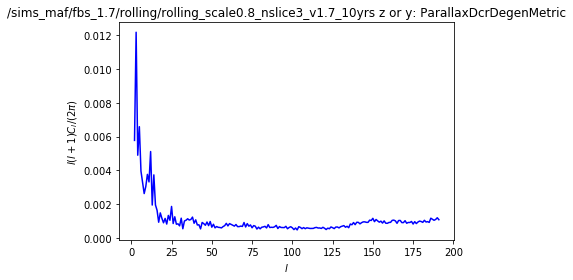

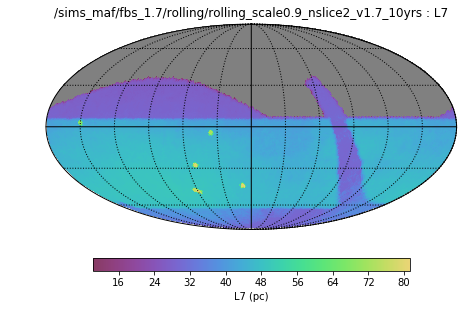

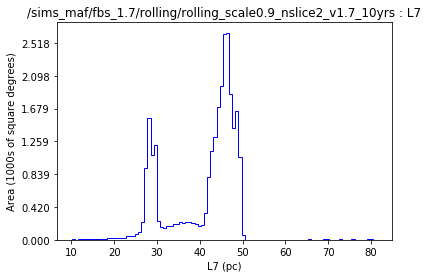

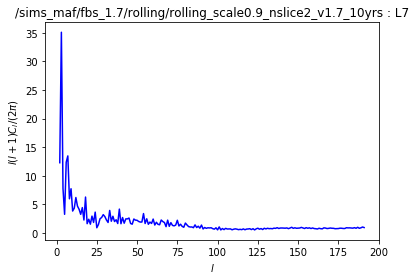

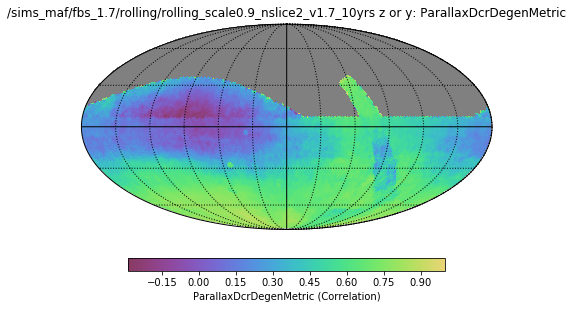

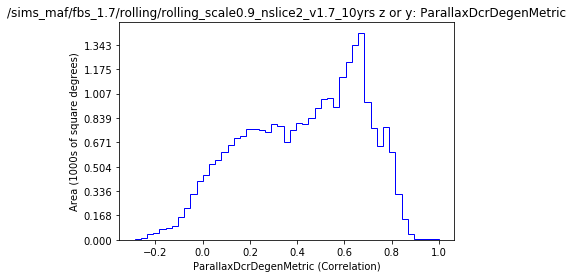

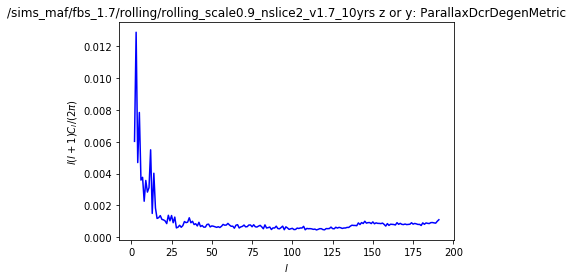

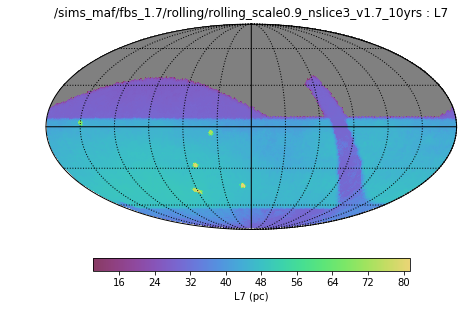

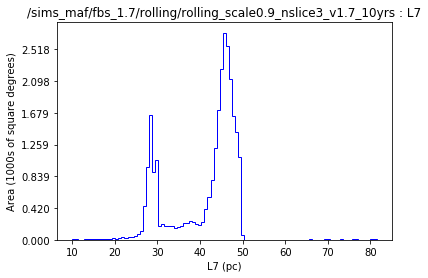

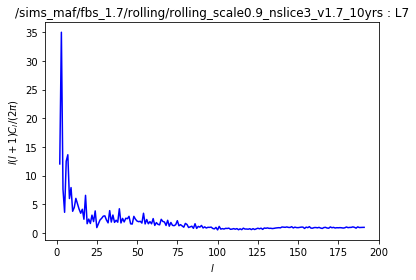

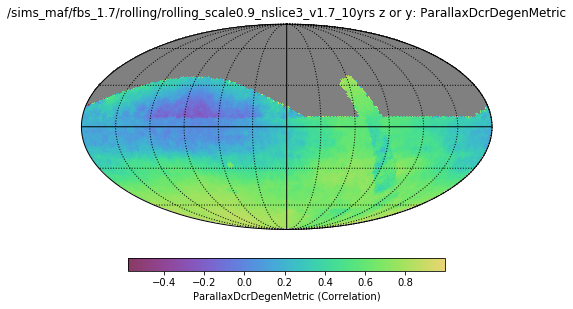

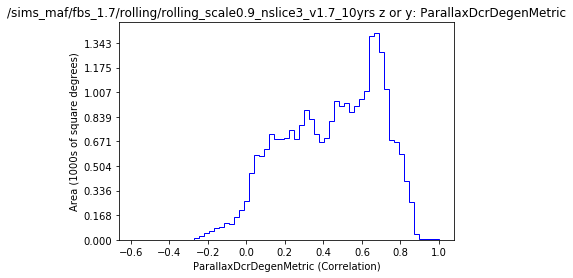

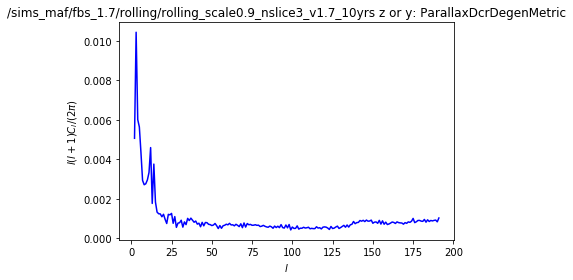

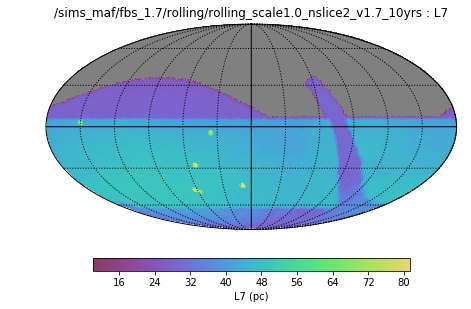

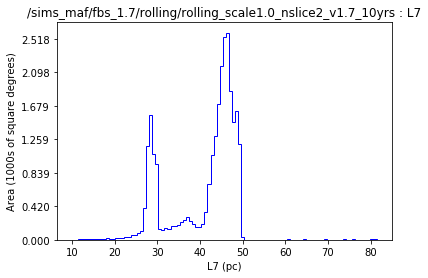

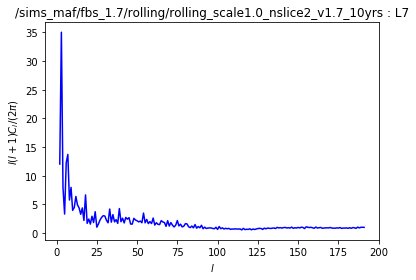

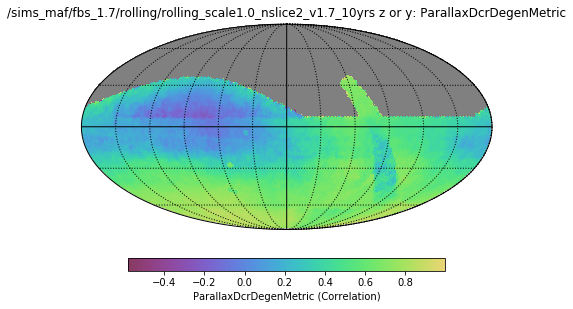

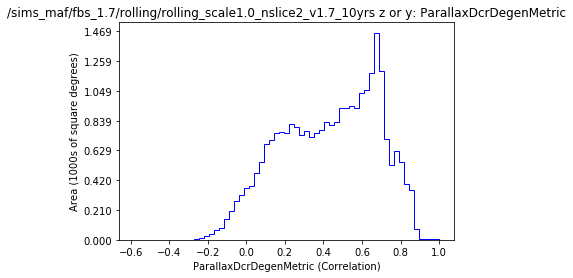

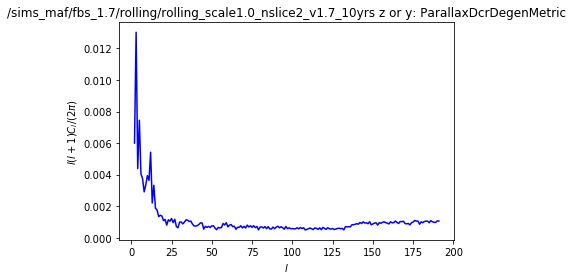

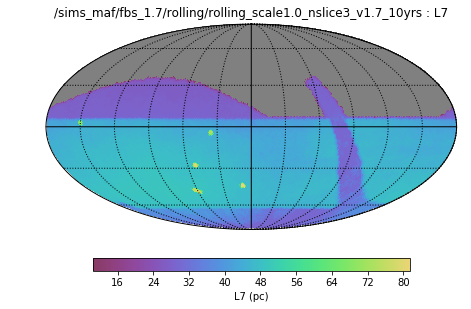

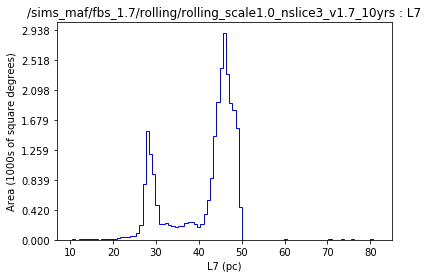

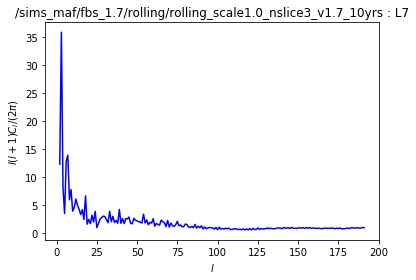

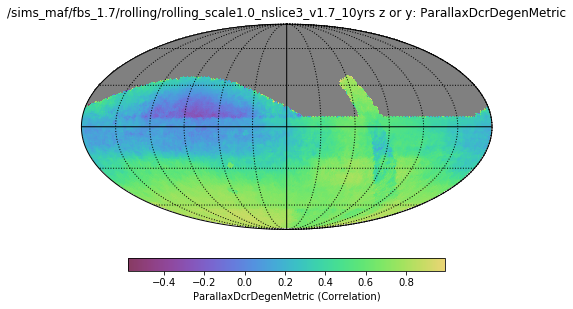

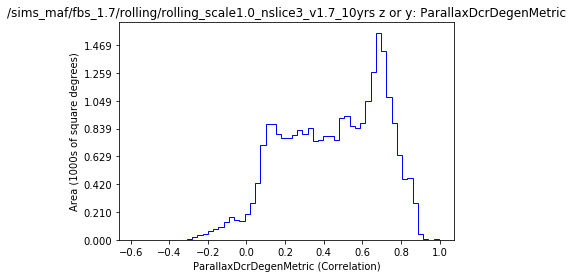

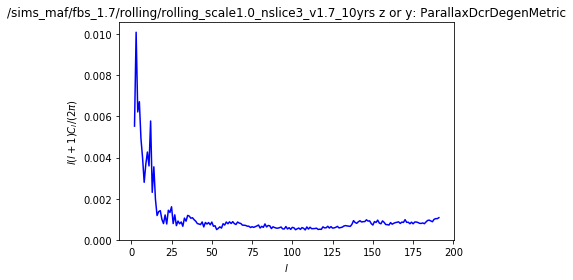

In [4]:
files = glob.glob('/sims_maf/fbs_1.7/rolling/*.db')
files.sort()
results = []
for dbFile in files:
    
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    
    outDir = runName + '_bdvol'
    outDir=outDir.replace('/sims_maf/fbs_1.7/rolling/',"BDresults/")
    resultsDb = db.ResultsDb(outDir=outDir)
    
    nside = 64
    bundleList = []
    #sql = 'filter="z" or filter="y"'
    sql = ''
    # Let's plug in the magnitudes for one type
    metric = BDParallaxMetric(mags={'i': 20.09, 'z': 18.18, 'y': 17.13}, metricName='L7')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [VolumeSumMetric(nside=nside)]
    plotDict = {}
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                                 summaryMetrics=summaryStats,
                                                 runName=runName))
    # add DCR degeneracy check...
    sql = 'filter="z" or filter="y"'
    metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.plotAll(closefigs=False)

    results.append(bg)

In [5]:
# Let's see how the total volume changes as we change the footprint
for name, result in zip(files, results):
    key = list(result.bundleDict.keys())[0]
    result.bundleDict[key]
    print(name, result.bundleDict[key].summaryValues)

/sims_maf/fbs_1.7/rolling/rolling_scale0.2_nslice2_v1.7_10yrs.db {'VolumeSum': 213073.53503574352}
/sims_maf/fbs_1.7/rolling/rolling_scale0.2_nslice3_v1.7_10yrs.db {'VolumeSum': 213027.08831203694}
/sims_maf/fbs_1.7/rolling/rolling_scale0.4_nslice2_v1.7_10yrs.db {'VolumeSum': 212939.20504086604}
/sims_maf/fbs_1.7/rolling/rolling_scale0.4_nslice3_v1.7_10yrs.db {'VolumeSum': 213269.49191852132}
/sims_maf/fbs_1.7/rolling/rolling_scale0.6_nslice2_v1.7_10yrs.db {'VolumeSum': 212857.9246547253}
/sims_maf/fbs_1.7/rolling/rolling_scale0.6_nslice3_v1.7_10yrs.db {'VolumeSum': 213409.10078385627}
/sims_maf/fbs_1.7/rolling/rolling_scale0.8_nslice2_v1.7_10yrs.db {'VolumeSum': 213324.96178175905}
/sims_maf/fbs_1.7/rolling/rolling_scale0.8_nslice3_v1.7_10yrs.db {'VolumeSum': 214232.8613291208}
/sims_maf/fbs_1.7/rolling/rolling_scale0.9_nslice2_v1.7_10yrs.db {'VolumeSum': 212967.2057205211}
/sims_maf/fbs_1.7/rolling/rolling_scale0.9_nslice3_v1.7_10yrs.db {'VolumeSum': 214210.82886525206}
/sims_maf/fbs